## Preprocessing ephys data for decoding

To decode, we need to:
1. Specify sort time intervals. Table involved: 
2. Remove artifact. Table involved: xx
3. Obtain spikes. Table involved: xx

In [3]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

[2023-10-08 14:42:27,454][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-10-08 14:42:27,491][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [4]:
nwb_file_name = 'eliot20221025.nwb'
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [5]:
# set the list of tetrodes to use for sorting
# NOTE: electrode group name is 0-based, need to subtract 1 from tetrode number
# for ginny 11-3
canula_1_tet_list = np.array([1,3,6,14,15]) - 1
canula_2_tet_list = np.array([17,18,21,27,28,30,31,32]) - 1
all_tet_list = np.concatenate([canula_1_tet_list,canula_2_tet_list])
all_tet_list

array([ 0,  2,  5, 13, 14, 16, 17, 20, 26, 27, 29, 30, 31])

### 1.specify what tetrodes to sort: ```SortGroup```

In [4]:
# NOTE only run this cell the first time you start with a new NWB file
# answer 'yes' when prompted - this will recreate the sort group table for the NWB file
# note: if you say yes to the delete step you will remove all downstream tables

# this is the populate command for the SortGroup table
# it will group the electrodes by tetrodes and associated the reference for each channel
# it will also remove the dead channels - from the yaml file

# SortGroup().set_group_by_shank(nwb_copy_file_name)

In [4]:
Electrode() & {'nwb_file_name' : nwb_copy_file_name} 

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
eliot20221027_.nwb,0,0,tetrode_12.5,0,0,31,0,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,0,1,tetrode_12.5,0,1,31,1,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,0,2,tetrode_12.5,0,2,31,2,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,0,3,tetrode_12.5,0,3,31,3,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,1,4,tetrode_12.5,0,0,31,4,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,1,5,tetrode_12.5,0,1,31,5,16,0.0,0.0,0.0,None,0.0,True,0.0,0.0,0.0,
eliot20221027_.nwb,1,6,tetrode_12.5,0,2,31,6,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,1,7,tetrode_12.5,0,3,31,7,16,0.0,0.0,0.0,None,0.0,True,0.0,0.0,0.0,
eliot20221027_.nwb,10,40,tetrode_12.5,0,0,31,40,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,10,41,tetrode_12.5,0,1,31,41,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [5]:
# check if dead channels are removed
from spyglass.common import Electrode
print('good electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} & {'bad_channel' : 'False'}).fetch('electrode_group_name').shape)
print('all electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} ).fetch('electrode_group_name').shape)

# find the reference for the 1st canula and the 2nd canula

canula_1_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 0}).fetch('original_reference_electrode')[0]
print('original canula 1 ref',canula_1_ref)
#canula_2_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
#       {'electrode_id' : 255}).fetch('original_reference_electrode')[0]

canula_2_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 127}).fetch('original_reference_electrode')[0]
print('original canula 2 ref',canula_2_ref)

good electrodes (83,)
all electrodes (128,)
canula 1 ref 16
canula 2 ref 76


#### Are they the same as your intended references? If not do the following 2 cells. If yes, skip.

In [7]:
(Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : 2-1}&
        {'bad_channel' : 'False'})

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
eliot20221027_.nwb,1,4,tetrode_12.5,0,0,31,4,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,1,6,tetrode_12.5,0,2,31,6,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [8]:
(Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : 19-1}&
        {'bad_channel' : 'False'})

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
eliot20221027_.nwb,18,72,tetrode_12.5,0,0,31,72,76,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,18,73,tetrode_12.5,0,1,31,73,76,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221027_.nwb,18,74,tetrode_12.5,0,2,31,74,76,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [9]:
# set reference here:
canula_1_ref = 4
canula_2_ref = 72

In [10]:
for tetrode in canula_1_tet_list:
    
    electrode_list = (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    
    electrode_group_list = (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
    sort_group_id=electrode_group_list[0]
    SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                    'sort_group_id' : sort_group_id,
                    'sort_reference_electrode_id' : canula_1_ref}, skip_duplicates=True)

    for ndx in range(len(electrode_list)):
        electrode_group_name = electrode_group_list[ndx]
        electrode_id = electrode_list[ndx]            
        SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : sort_group_id,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)

for tetrode in canula_2_tet_list:
    
    electrode_list = (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    
    electrode_group_list = (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
    sort_group_id=electrode_group_list[0]
    SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                    'sort_group_id' : sort_group_id,
                    'sort_reference_electrode_id' : canula_2_ref}, skip_duplicates=True)

    for ndx in range(len(electrode_list)):
        electrode_group_name = electrode_group_list[ndx]
        electrode_id = electrode_list[ndx]            
        SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : sort_group_id,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)


### Include two more tetrodes sort group for lick artifact

In [11]:
# this is a way to make a new sort group that includes several tetrodes that will be used for artifact detection
# we want to make one for each canula 
# tetrodes 1-32 > sort_group_id = 100
# tetrodes 33-64 > sort_group_id = 101
# use the values above for the sort_reference_electrode_id
electrode_list = []
electrode_group_list = []
for tetrode in canula_1_tet_list:
    electrode_list = electrode_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    electrode_group_list = electrode_group_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
#electrode_list
SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                    'sort_group_id' : 100,
                    'sort_reference_electrode_id' : canula_1_ref}, skip_duplicates=True)

for ndx in range(len(electrode_list)):
    electrode_group_name = electrode_group_list[ndx]
    electrode_id = electrode_list[ndx]            
    SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : 100,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)

electrode_list = []
electrode_group_list = []
for tetrode in canula_2_tet_list:
    electrode_list = electrode_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    electrode_group_list = electrode_group_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
#electrode_list
SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                       'sort_group_id' : 101,
                       'sort_reference_electrode_id' : canula_2_ref}, skip_duplicates=True)

for ndx in range(len(electrode_list)):
    electrode_group_name = electrode_group_list[ndx]
    electrode_id = electrode_list[ndx]            
    SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : 101,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)    

    
    

In [12]:
(SortGroup & {'nwb_file_name' : nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
eliot20221027_.nwb,0,4
eliot20221027_.nwb,2,4
eliot20221027_.nwb,5,4
eliot20221027_.nwb,13,4
eliot20221027_.nwb,14,4
eliot20221027_.nwb,16,72
eliot20221027_.nwb,17,72
eliot20221027_.nwb,20,72
eliot20221027_.nwb,26,72
eliot20221027_.nwb,27,72


### 2. sort intervals: ```SortInterval```,```IntervalList```,```SpikeSortingRecordingSelection```

In [4]:
IntervalList_pd=pd.DataFrame(IntervalList & {'nwb_file_name': nwb_copy_file_name})

In [5]:
IntervalList_pd

,nwb_file_name,interval_list_name,valid_times
0,eliot20221027_.nwb,01_Seq2Sleep1,"[[1666893700.8502011, 1666895236.8471606]]"
1,eliot20221027_.nwb,02_Seq2Session1,"[[1666895672.1816, 1666897584.1470187]]"
2,eliot20221027_.nwb,03_Seq2Sleep2,"[[1666897718.1673455, 1666899603.3474085]]"
3,eliot20221027_.nwb,04_Seq2Session2,"[[1666899696.8677373, 1666901495.2471597]]"
4,eliot20221027_.nwb,05_Seq2Sleep3,"[[1666901722.1653614, 1666903456.4474614]]"
...,...,...,...
251,eliot20221027_.nwb,pos 8 valid times,"[[1666908781.7418318, 1666909932.9049954], [16..."
252,eliot20221027_.nwb,pos 9 valid times,"[[1666910593.764054, 1666912194.7318144]]"
253,eliot20221027_.nwb,raw data valid times,"[[1666893700.8500361, 1666895236.8471844], [16..."
254,eliot20221027_.nwb,spikesort_maze,"[[1666895672.1816, 1666897584.1470187], [16668..."


### Select Sleep data or run data

In [6]:
interval_pd=pd.DataFrame((TaskEpoch & {'nwb_file_name':nwb_copy_file_name}).fetch())
interval_pd.insert(5, "pos_name", '')

In [7]:
# select position timestamps, only maze sessions or sleep are selected
session_interval=[]
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[0:3]=='pos':
        interval_pd.loc[int(interval[4:6]),'pos_name']=interval

In [8]:
interval_pd

,nwb_file_name,epoch,task_name,camera_name,interval_list_name,pos_name,task_environment,camera_names
0,eliot20221027_.nwb,1,sleep,None,01_Seq2Sleep1,pos 0 valid times,none,[{'camera_name': 'sleep_camera'}]
1,eliot20221027_.nwb,2,maze,None,02_Seq2Session1,pos 1 valid times,none,[{'camera_name': 'maze_camera'}]
2,eliot20221027_.nwb,3,sleep,None,03_Seq2Sleep2,pos 2 valid times,none,[{'camera_name': 'sleep_camera'}]
3,eliot20221027_.nwb,4,maze,None,04_Seq2Session2,pos 3 valid times,none,[{'camera_name': 'maze_camera'}]
4,eliot20221027_.nwb,5,sleep,None,05_Seq2Sleep3,pos 4 valid times,none,[{'camera_name': 'sleep_camera'}]
5,eliot20221027_.nwb,6,maze,None,06_Seq2Session3,pos 5 valid times,none,[{'camera_name': 'maze_camera'}]
6,eliot20221027_.nwb,7,sleep,None,07_Seq2Sleep4,pos 6 valid times,none,[{'camera_name': 'sleep_camera'}]
7,eliot20221027_.nwb,8,maze,None,08_Seq1Session4,pos 7 valid times,none,[{'camera_name': 'maze_camera'}]
8,eliot20221027_.nwb,9,sleep,None,09_Seq1Sleep5,pos 8 valid times,none,[{'camera_name': 'sleep_camera'}]
9,eliot20221027_.nwb,10,maze,None,10_Seq1Session5,pos 9 valid times,none,[{'camera_name': 'maze_camera'}]


### Section A: for run sessions

In [34]:
# get times
session_interval=list(interval_pd.loc[interval_pd.task_name=='maze','interval_list_name'])
intvls=[]
for ses_intvl in session_interval:
    intvl=(IntervalList & {'nwb_file_name' : nwb_copy_file_name,
                            'interval_list_name' : ses_intvl}).fetch1('valid_times')
    intvls.append(intvl)
    
    SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : ses_intvl,
                     'sort_interval' : intvl}, skip_duplicates=True)

sort_interval = np.concatenate(intvls)
sort_interval_name = 'spikesort_maze'

# insert new combined interval into BOTH sortinterval table and intervallist table
# try sort interval that has two separate sessions - variable: 'sort interval'
SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : sort_interval_name,
                     'sort_interval' : sort_interval}, skip_duplicates=True)
IntervalList.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'interval_list_name' : sort_interval_name,
                     'valid_times' : sort_interval}, skip_duplicates=True)

### Section B: for sleep sessions

In [9]:
# get times
session_interval=list(interval_pd.loc[interval_pd.task_name=='sleep','interval_list_name'])
intvls=[]
for ses_intvl in session_interval:
#for pos_intvl in position_interval:
    intvl=(IntervalList & {'nwb_file_name' : nwb_copy_file_name,
                            'interval_list_name' : ses_intvl}).fetch1('valid_times')
    intvls.append(intvl)
    
    SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : ses_intvl,
                     'sort_interval' : intvl}, skip_duplicates=True)

sort_interval = np.concatenate(intvls)
sort_interval_name = 'spikesort_sleep'

# insert new combined interval into BOTH sortinterval table and intervallist table
# try sort interval that has two separate sessions - variable: 'sort interval'
SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : sort_interval_name,
                     'sort_interval' : sort_interval}, skip_duplicates=True)
IntervalList.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'interval_list_name' : sort_interval_name,
                     'valid_times' : sort_interval}, skip_duplicates=True)

In [10]:
session_interval

['01_Seq2Sleep1',
 '03_Seq2Sleep2',
 '05_Seq2Sleep3',
 '07_Seq2Sleep4',
 '09_Seq1Sleep5',
 '11_Seq2Sleep6',
 '13_Seq1Sleep7']

In [22]:
SortInterval & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_interval_name name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
eliot20221027_.nwb,01_Seq2Sleep1,=BLOB=
eliot20221027_.nwb,02_Seq2Session1,=BLOB=
eliot20221027_.nwb,03_Seq2Sleep2,=BLOB=
eliot20221027_.nwb,04_Seq2Session2,=BLOB=
eliot20221027_.nwb,05_Seq2Sleep3,=BLOB=
eliot20221027_.nwb,06_Seq2Session3,=BLOB=
eliot20221027_.nwb,07_Seq2Sleep4,=BLOB=
eliot20221027_.nwb,08_Seq1Session4,=BLOB=
eliot20221027_.nwb,09_Seq1Sleep5,=BLOB=
eliot20221027_.nwb,10_Seq1Session5,=BLOB=


In [126]:
#(IntervalList & {'nwb_file_name': nwb_copy_file_name}).fetch('interval_list_name')

In [36]:
def sort_selection(tetrode_sort_interval_name):
    tetrode=tetrode_sort_interval_name[0]
    sort_interval_name=tetrode_sort_interval_name[1]
    print('create recording for tet',str(tetrode))  
    key = dict()
    key['nwb_file_name'] = nwb_copy_file_name
    key['sort_group_id'] = tetrode
    key['sort_interval_name'] = sort_interval_name
    key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
    key['interval_list_name'] = sort_interval_name
    key['team_name'] = 'SequenceTask'

    ssr_key1 = key

    SpikeSortingRecordingSelection.insert1(ssr_key1, skip_duplicates=True)
    SpikeSortingRecording.populate(ssr_key1)

In [37]:
for t in all_tet_list:
    for s in session_interval:
        sort_selection((t,s))

for t in [100,101]:
    for s in session_interval:
        sort_selection((t,s))

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 2


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 13


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 14


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 16


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 17


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 26


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 27


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 29


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/192 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/170 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/158 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/161 [00:00<?, ?it/s]

create recording for tet 101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/162 [00:00<?, ?it/s]

In [41]:
len((SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}))

195

In [42]:
(SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
eliot20221027_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,08_Seq1Session4,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_08_Seq1Session4_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_08_Seq1Session4_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,09_Seq1Sleep5,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_09_Seq1Sleep5_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_09_Seq1Sleep5_0_franklab_tetrode_hippocampus
eliot20221027_.nwb,0,10_Seq1Session5,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/eliot20221027_.nwb_10_Seq1Session5_0_franklab_tetrode_hippocampus,eliot20221027_.nwb_10_Seq1Session5_0_franklab_tetrode_hippocampus


#### If the `SpikeSortingRecording` table is filled, jump to Artifact detection section.
If run only one tetrode

In [23]:
tetrode=100
sort_interval_name='04_Seq2Session2'
sort_selection([tetrode,sort_interval_name])

tetrode=101
sort_interval_name='04_Seq2Session2'
sort_selection([tetrode,sort_interval_name])

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

OSError: [Errno 39] Directory not empty: '/stelmo/nwb/recording/eliot20221018_.nwb_04_Seq2Session2_100_franklab_tetrode_hippocampus'

In [40]:
SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name,'sort_group_id':100}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
eliot20221027_.nwb,100,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,01_Seq2Sleep1
eliot20221027_.nwb,100,02_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,02_Seq2Session1
eliot20221027_.nwb,100,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,03_Seq2Sleep2
eliot20221027_.nwb,100,04_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,04_Seq2Session2
eliot20221027_.nwb,100,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,05_Seq2Sleep3
eliot20221027_.nwb,100,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,06_Seq2Session3
eliot20221027_.nwb,100,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,07_Seq2Sleep4
eliot20221027_.nwb,100,08_Seq1Session4,franklab_tetrode_hippocampus,SequenceTask,08_Seq1Session4
eliot20221027_.nwb,100,09_Seq1Sleep5,franklab_tetrode_hippocampus,SequenceTask,09_Seq1Sleep5
eliot20221027_.nwb,100,10_Seq1Session5,franklab_tetrode_hippocampus,SequenceTask,10_Seq1Session5


#### Do parallel processing across tetrodes

In [108]:
selections=[]
for t in all_tet_list:
    for s in session_interval:
        selections.append((t,s))
selections_alltet=[]
for t in [100,101]:
    for s in session_interval:
        selections_alltet.append((t,s))

In [109]:
len(selections)+len(selections_alltet)

90

In [57]:
# if one session
selections=[]
for t in all_tet_list:
    s='04_Seq2Session2'
    selections.append((t,s))

In [23]:
SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name,'sort_group_id':101}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
eliot20221018_.nwb,101,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,02_Seq2Session1
eliot20221018_.nwb,101,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,04_Seq2Session2
eliot20221018_.nwb,101,05_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,05_Seq2Session3
eliot20221018_.nwb,101,07_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,07_Seq2Session4
eliot20221018_.nwb,101,09_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,09_Seq2Session5
eliot20221018_.nwb,101,11_Seq2Session6,franklab_tetrode_hippocampus,Shijie Gu,11_Seq2Session6


In [ ]:
numWorker=40 #len(selections)
print('num of worker:',numWorker)
with multiprocessing.Pool(numWorker) as p:
    p.map(sort_selection,selections)
    
numWorker=len(all_tet_list)
print('num of worker:',numWorker)
with multiprocessing.Pool(numWorker) as p:
    p.map(sort_selection,selections_alltet)

num of worker: 40
create recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tet create recording for tetcreate recording for tet create recording for tetcreate recording for tet create recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tet  create recording for tet create recording for tetcreate recording for tetcreate recording for tetcreate recording for tet create recording for tet create recording for tet  create recording for tetcreate recording for tetcreate recording for tet0 create recording for tet create recording for tetcreate recording for tetcreate recording for tet  create recording for tet0create recording for tet   create recording for tet 0 2  4     200  04   2
5   42  5
 25 4134

2541313

[2023-05-26 14:44:27,723][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,723][WARNING]: MySQL server has gone away. Reconnecting to the server.


[2023-05-26 14:44:27,724][WARNING]: MySQL server has gone away. Reconnecting to the server.


[2023-05-26 14:44:27,728][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,728][WARNING]: MySQL server has gone away. Reconnecting to the server.


create recording for tet

[2023-05-26 14:44:27,729][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,729][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,732][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,733][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,732][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,734][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,729][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,733][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,733][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,734][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,733][WARNING]: MySQL server has gone away. Reconnecting to 

create recording for tet

[2023-05-26 14:44:27,732][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,734][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,734][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,732][WARNING]: MySQL server has gone away. Reconnecting to the server.


[2023-05-26 14:44:27,734][WARNING]: MySQL server has gone away. Reconnecting to the server.


13

13



[2023-05-26 14:44:27,752][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-26 14:44:27,753][WARNING]: MySQL server has gone away. Reconnecting to the server.
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWa

create recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


  create recording for tet    17create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


1716create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


16 2017

 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 create recording for tet20
 create recording for tet
create recording for tet
17
17

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


17  20

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)





20

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


20


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

create recording for tetcreate recording for tet  2320

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8



create recording for tetcreate recording for tet 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet23

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



create recording for tet create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 23

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


26create recording for tet
 create recording for tet23 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet   

26

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


2326create recording for tet 23create recording for tet

 2626create recording for tet



/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet create recording for tet create recording for tet27

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


27create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet
 
 26 27create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tetcreate recording for tet 
27

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 create recording for tetcreate recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


2728 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



 

  28 28
27
create recording for tet
create recording for tet
 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 create recording for tet292928


 28

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


28

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



create recording for tet 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 create recording for tet2929

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


29

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


  3030 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/backends/hdf5/h5tools.py:615: BrokenLinkWarning: Path to Group altered/broken at /general/extracellular_ephys/electrodes/ref_elect_id
  warnings.warn('Path to Group altered/broken at ' + os.path.join(h5obj.name, k), BrokenLinkWarning)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



29

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)




create recording for tetcreate recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


 30

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


30  

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



30

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/backends/hdf5/h5tools.py:615: BrokenLinkWarning: Path to Group altered/broken at /general/extracellular_ephys/electrodes/y
  warnings.warn('Path to Group altered/broken at ' + os.path.join(h5obj.name, k), BrokenLinkWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


30create recording for tet


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


31 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet 31

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



31

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



31

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


create recording for tet 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


31


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)



31

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/190 [00:00<?, ?it/s]

In [ ]:
SpikeSortingRecording.populate()

In [ ]:
numWorker=len(all_tet_list)*4
with multiprocessing.Pool(numWorker) as p:
    p.map(sort_selection,selections_alltet)

create recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tet create recording for tetcreate recording for tet      100  101101 100100
100100101
101

101





write_binary_recording with n_jobs 1  chunk_size 178571428
write_binary_recording with n_jobs 1  chunk_size 89285714write_binary_recording
 with n_jobs 1  chunk_size 89285714
write_binary_recording with n_jobs 1  chunk_size 178571428
write_binary_recordingwrite_binary_recording  with withn_jobs  n_jobs1   chunk_size1  178571428 chunk_size
 89285714
write_binary_recording with n_jobs 1  chunk_size 89285714
write_binary_recording with n_jobs 1  chunk_size 178571428
write_binary_recording with n_jobs 1  chunk_size 178571428
write_binary_recording with n_jobs 1  chunk_size 89285714


In [59]:
nwb_copy_file_name

'eliot20221022_.nwb'

In [4]:
SpikeSortingRecording.populate({'nwb_file_name': nwb_copy_file_name,
                                'sort_group_id':101,
                                'sort_interval_name':'02_Seq2Session1'})

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/203 [00:00<?, ?it/s]

In [61]:
(SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
eliot20221022_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus
eliot20221022_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus,eliot20221022_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus


In [60]:
SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
eliot20221022_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,Shijie Gu,01_Seq2Sleep1
eliot20221022_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,02_Seq2Session1
eliot20221022_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,Shijie Gu,03_Seq2Sleep2
eliot20221022_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,04_Seq2Session2
eliot20221022_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,Shijie Gu,05_Seq2Sleep3
eliot20221022_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,06_Seq2Session3
eliot20221022_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,Shijie Gu,07_Seq2Sleep4
eliot20221022_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,08_Seq2Session4
eliot20221022_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,Shijie Gu,09_Seq2Sleep5
eliot20221022_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,10_Seq2Session5


In [82]:
(SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name,'sort_interval_name':'09_Seq2Sleep5','sort_group_id':100}) 

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
eliot20221022_.nwb,100,09_Seq2Sleep5,franklab_tetrode_hippocampus,Shijie Gu,/stelmo/nwb/recording/eliot20221022_.nwb_09_Seq2Sleep5_100_franklab_tetrode_hippocampus,eliot20221022_.nwb_09_Seq2Sleep5_100_franklab_tetrode_hippocampus


In [62]:
len(selections)+len(selections_alltet)

NameError: name 'selections' is not defined

### 3. artifact detection

In [38]:
#dj.ERD(ArtifactDetectionSelection)-3+3

In [63]:
param_dict = dict()
param_dict['zscore_thresh'] = None
param_dict['amplitude_thresh'] = 100
param_dict['proportion_above_thresh'] = 0.5
param_dict['removal_window_ms'] = 2
artifact_params_name='ampl_100_prop_05_2ms'
ArtifactDetectionParameters.insert1({'artifact_params_name': artifact_params_name,
                                     'artifact_params': param_dict}, skip_duplicates=True)

#### for one or two tetrode, one session

In [89]:
#%%capture stored_output

#sort_interval_name = 'spikesort_maze'
sort_interval_name = '03_Seq2Sleep2'
artifact_key = {'nwb_file_name' : nwb_copy_file_name,
                'sort_interval_name' : sort_interval_name,
                'sort_group_id' : 100,
                'preproc_params_name': 'franklab_tetrode_hippocampus',
                'team_name': 'Shijie Gu'}  

artifact_key['artifact_params_name'] = artifact_params_name

ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)
ArtifactDetection.populate([(ArtifactDetectionSelection & artifact_key).proj()])

artifact_key['sort_group_id']=101
ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)
ArtifactDetection.populate([(ArtifactDetectionSelection & artifact_key).proj()])

using 4 jobs...


detect_artifact_frames:   0%|          | 0/387 [00:00<?, ?it/s]

In [86]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipykernel/kernelbase.py(1205)_input_request()
   1203             except KeyboardInterrupt:
   1204                 # re-raise KeyboardInterrupt, to truncate traceback
-> 1205                 raise KeyboardInterrupt("Interrupted by user") from None
   1206             except Exception:
   1207                 self.log.warning("Invalid Message:", exc_info=True)



ipdb>  exit


In [ ]:

#ArtifactDetection.populate(ArtifactDetectionSelection)


In [31]:
ArtifactDetectionSelection & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,custom_artifact_detection
eliot20221018_.nwb,100,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,ampl_100_prop_05_2ms,0
eliot20221018_.nwb,101,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,ampl_100_prop_05_2ms,0


In [176]:
ArtifactDetection & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,artifact_times np array of artifact intervals,artifact_removed_valid_times np array of valid no-artifact intervals,artifact_removed_interval_list_name name of the array of no-artifact valid time intervals


#### for batch processing

In [3]:
def artifact_selection(tetrode_sort_interval_name):
    tetrode=tetrode_sort_interval_name[0]
    sort_interval_name=tetrode_sort_interval_name[1]
    artifact_params_name=tetrode_sort_interval_name[2]
    print('artifact for tet',str(tetrode))  

    key = dict()
    key['nwb_file_name'] = nwb_copy_file_name
    key['sort_group_id'] = tetrode
    key['sort_interval_name'] = sort_interval_name
    key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
    key['team_name'] = 'SequenceTask'
    key['artifact_params_name'] = artifact_params_name

    ssr_key1 = key

    ArtifactDetectionSelection.insert1(ssr_key1, skip_duplicates=True)
    ArtifactDetection.populate([(ArtifactDetectionSelection & ssr_key1).proj()])

In [11]:
session_interval

['01_Seq2Sleep1',
 '03_Seq2Sleep2',
 '05_Seq2Sleep3',
 '07_Seq2Sleep4',
 '09_Seq1Sleep5',
 '11_Seq2Sleep6',
 '13_Seq1Sleep7']

In [12]:
selections_100101=[]
for t in [100,101]:
    for s in session_interval:
        artifact_selection((t,s,'ampl_100_prop_05_2ms'))
        #selections_100101.append((t,s,'ampl_100_prop_05_2ms'))
#selections_100101

artifact for tet 100
artifact for tet 100
artifact for tet 100
artifact for tet 100
artifact for tet 100
artifact for tet 100
artifact for tet 100
artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/154 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/189 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/174 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/171 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/174 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/167 [00:00<?, ?it/s]

artifact for tet 101
using 4 jobs...


detect_artifact_frames:   0%|          | 0/203 [00:00<?, ?it/s]

In [51]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(468)interval_set_difference_inds()
    466     i = j = 0
    467     while i < len(intervals1) and j < len(intervals2):
--> 468         if intervals1[i][1] <= intervals2[j][0]:
    469             result.append(intervals1[i])
    470             i += 1



ipdb>  intervals2


[9607278, 9607341]


ipdb>  j


*** The 'jump' command requires a line number


ipdb>  intervals2[j]


9607278


ipdb>  intervals1


[(0, 46079881)]


ipdb>  intervals1[i][1]


46079881


ipdb>  intervals2


[9607278, 9607341]


ipdb>  intervals1


[(0, 46079881)]


ipdb>  up


> /home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/spikesorting_artifact.py(269)_get_artifact_times()
    267 
    268     # compute set difference between intervals (of indices)
--> 269     artifact_removed_valid_times_ind = interval_set_difference_inds(
    270         [(0, len(valid_timestamps) - 1)], artifact_intervals_new
    271     )



ipdb>  artifact_intervals_new


[9607278, 9607341]


ipdb>  exit


In [70]:
(ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name} ).fetch('sort_group_id')

array([  0,   0,   0,   0,   0,   2,   2,   2,   2,   2,   4,   4,   4,
         4,   4,   5,   5,   5,   5,   5,  13,  13,  13,  13,  13,  14,
        14,  14,  14,  14,  16,  16,  16,  16,  16,  17,  17,  17,  17,
        17,  20,  20,  20,  20,  20,  23,  23,  23,  23,  23,  26,  26,
        26,  26,  26,  27,  27,  27,  27,  27,  28,  28,  28,  28,  28,
        29,  29,  29,  29,  29,  30,  30,  30,  30,  30,  31,  31,  31,
        31,  31, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101,
       101, 101, 101])

In [50]:
ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name,'sort_interval_name':'03_Seq2Sleep2'}

artifact_removed_interval_list_name,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,artifact_removed_valid_times,artifact_times np array of artifact intervals
eliot20221027_.nwb_03_Seq2Sleep2_100_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times,eliot20221027_.nwb,100,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,ampl_100_prop_05_2ms,=BLOB=,=BLOB=


In [52]:
#for i in range(len(all_tet_list)):
#    (ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name, 'sort_group_id':all_tet_list[i]}).delete()

Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  s
Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
Deleting 1 rows from `spikesorting_artifact`.`artifact_removed_interval_list`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 0 rows from `spikesorting_artifact`.`artifact_removed_interval_list`
Nothing to delete.
Deleting 1 rows from `decoding_clusterless`.`__unit_marks_indicator`
Deleting 1 rows from `decoding_clusterless`.`#unit_marks_indicator_selection`
Deleting 1 rows from `decoding_clusterless`.`__unit_marks`
Deleting 1 rows from `decoding_clusterless`.`unit_mark_parameters`
Deleting 4 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
Deleting 1 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
Deleting 1 rows from `spikesorting_curation`.`curation`
Deleting 1 rows from `spikesorting_sorting`.`__spike_sorting`
Deleting 1 rows from `spikesorting_sorting`.`spike_sorting_selection`
De

Commit deletes? [yes, No]:  yes


Deletes committed.


In [51]:
all_tet_list

array([ 0,  2,  3,  6,  7,  9, 10, 12, 15, 17, 18, 20, 24, 25, 27, 34, 35,
       37, 39, 40, 41, 46, 50, 52, 53, 55, 56, 60, 61])

In [69]:
artifact_selection([41, '06_Seq2Session3', 'ampl_1500_prop_075_1ms'])
artifact_selection([41, '08_Seq2Session4', 'ampl_1500_prop_075_1ms'])

artifact for tet 41
7 artifact intervals detected;          0.00040849187173419446 % of the recording's valid_timestamps removed as artifact
artifact for tet 41
3 artifact intervals detected;          0.00022784656467692794 % of the recording's valid_timestamps removed as artifact


In [54]:
stored_output.show()

num of worker: 12


### 4. plot data from recording

In [39]:
import spikeinterface as si

tetrode=101
sort_group = 101
session_name='02_Seq2Session1'
sort_interval_name='02_Seq2Session1'

# get session start time
session_start_end=(IntervalList & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':session_name}).fetch1('valid_times')

# obtain neural data
recording_path = (SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name,
                                           'sort_interval_name' : sort_interval_name,
                                           'sort_group_id' : tetrode}).fetch1('recording_path')
recording = si.load_extractor(recording_path)
if recording.get_num_segments() > 1 and isinstance(recording, si.AppendSegmentRecording):
    recording = si.concatenate_recordings(recording.recording_list)
elif recording.get_num_segments() > 1 and isinstance(recording, si.BinaryRecordingExtractor):
    recording = si.concatenate_recordings([recording])

valid_timestamps = SpikeSortingRecording._get_recording_timestamps(recording)

# ripple band data
ripple_eseries=(LFPBand() & {'nwb_file_name' : nwb_copy_file_name}).fetch_nwb()[0]['filtered_data']
ripple_thresh=2*np.std(ripple_eseries.data)

# artifact time
artifact_plot_times = (ArtifactDetection 
                       & {'nwb_file_name' : nwb_copy_file_name} 
                       & {'sort_interval_name' : sort_interval_name} 
                       & {'sort_group_id' : sort_group}
                       & {'artifact_params_name': artifact_params_name}).fetch1('artifact_times')

IndexError: list index out of range

76


Text(0.5, 1.0, 'percentage of electrode: 0.8392857142857143 \n min into session 1.9393630146980285')

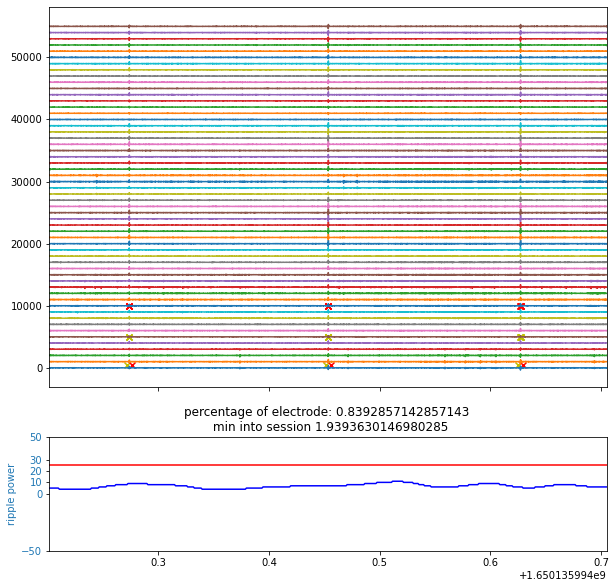

In [290]:
#artifact_num = 22
artifact_num=artifact_num+2
print(artifact_num)

plottimes = [artifact_plot_times[artifact_num][0]-0.25, artifact_plot_times[artifact_num][1]+0.25]
#plottimes = [artifact_plot_times[artifact_num][0]-0.1, artifact_plot_times[artifact_num][1]+0.1]
#plottimes = [artifact_plot_times[artifact_num][0]-1, artifact_plot_times[artifact_num][1]+1]

orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()
neural_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1]+1)
time_into_recording=(np.mean(artifact_plot_times[artifact_num])-session_start_end[0][0])/60

lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

fig, axes = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [10,3]},sharex=True,figsize=(10,10))
numtrodes=np.shape(neural_data)[1]
for i in range(numtrodes):
    #plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
    axes[0].plot(valid_timestamps[orig_time_ind], neural_data[:,i]+i*1000)

color = 'tab:blue'
axes[1].set_ylabel('ripple power', color=color)  # we already handled the x-label with ax1
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], ripple_smooth[lfp_time_ind], 'b-')
axes[1].set_ylim(np.array([-50,50]))
axes[1].plot(plottimes,[ripple_thresh,ripple_thresh],'r-')
axes[1].set_yticks(np.array([-50,0,10,20,30,50]))
axes[1].tick_params(axis='y', labelcolor=color)

# times when more than 12 tetrodes of more than >200 uV
largenum=np.sum(np.abs(neural_data)>200,axis=1)
artifact_plot_times_=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

largenum=np.sum(np.abs(neural_data)>150,axis=1)
artifact_plot_times_2=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

axes[0].scatter(artifact_plot_times_, np.repeat(5000,artifact_plot_times_.shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times_2, np.repeat(10000,artifact_plot_times_2.shape[0]),marker='x',color='r')

# start and end time of artifact
axes[0].scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])
plt.title('percentage of electrode: '+str(np.max(largenum)/numtrodes)+' \n min into session '+str(time_into_recording))

## End here

In [277]:
def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition.astype(int))
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        print('condition 0')
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        print('condition 1')
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx

In [362]:
ripple_thresh=2*np.std(ripple_eseries.data[:,0])
ripple_thresh

24.940082302614492

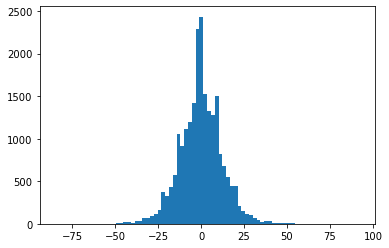

In [383]:
plt.hist(ripple_eseries.data[::100],bins=80);

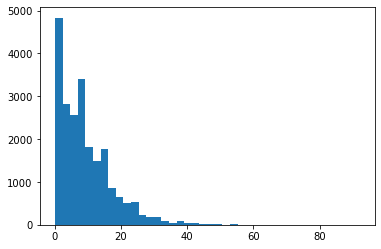

In [382]:
plt.hist(np.abs(ripple_eseries.data[::100]),bins=80);

In [308]:
from scipy.ndimage.filters import gaussian_filter1d

ripple_smooth=gaussian_filter1d(np.array(np.abs(ripple_eseries.data[:,0])),15,mode='constant')

In [363]:
ripple_intervals=contiguous_regions(ripple_smooth>=ripple_thresh) #index

In [365]:
ripple_times=ripple_intervals.copy().astype('float')
ripple_times[:,0]=ripple_eseries.timestamps[ripple_intervals[:,0]]
ripple_times[:,1]=ripple_eseries.timestamps[ripple_intervals[:,1]-1]
ripple_ind=np.diff(ripple_times,axis=1)>=0.015
ripple_times=ripple_times[ripple_ind.ravel()]
ripple_intervals=ripple_intervals[ripple_ind.ravel()]
#ripple_times

In [366]:
np.shape(ripple_times) #20

(152, 2)

22
[1650136378.3928502, 1650136378.9278505]
[]


Text(0.5, 1.0, 'percentage of electrode: 0.10714285714285714 \n min into session 1.9393630146980285')

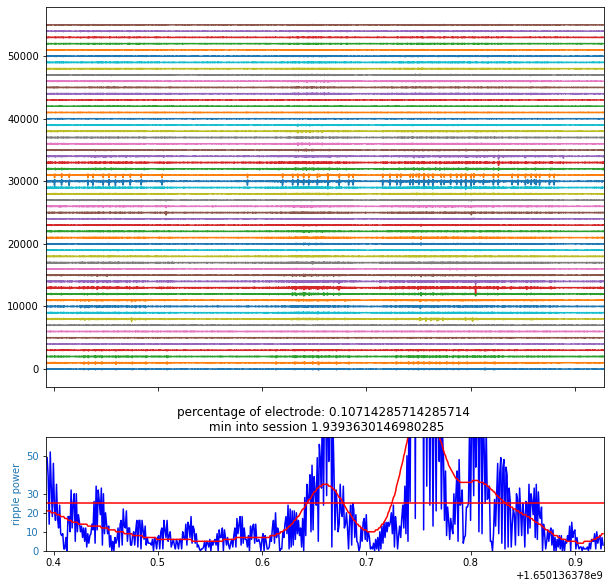

In [396]:
ripple_num=22
#ripple_num=ripple_num+1
print(ripple_num)

plottimes = [ripple_times[ripple_num][0]-0.25, ripple_times[ripple_num][1]+0.25]
print(plottimes)
#plottimes = [ripple_times[ripple_num][0], ripple_times[ripple_num][1]]
#plottimes = [artifact_plot_times[artifact_num][0]-1, artifact_plot_times[artifact_num][1]+1]

orig_time_ind = np.argwhere(np.logical_and(valid_timestamps >= plottimes[0], valid_timestamps < plottimes[1])).ravel()
neural_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1]+1)
time_into_recording=(np.mean(artifact_plot_times[artifact_num])-session_start_end[0][0])/60

lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

fig, axes = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [10,3]},sharex=True,figsize=(10,10))
numtrodes=np.shape(neural_data)[1]
for i in range(numtrodes):
    axes[0].plot(valid_timestamps[orig_time_ind], neural_data[:,i]+i*1000)

color = 'tab:blue'
axes[1].set_ylabel('ripple power', color=color)  # we already handled the x-label with ax1
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], np.abs(ripple_eseries.data[lfp_time_ind,0]), 'b-')
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], np.abs(ripple_smooth[lfp_time_ind]), 'r-')
axes[1].set_ylim(np.array([0,60]))
axes[1].plot(plottimes,[ripple_thresh,ripple_thresh],'r-')
axes[1].set_yticks(np.array([0,10,20,30,50]))
axes[1].tick_params(axis='y', labelcolor=color)

# times when more than 12 tetrodes of more than >200 uV
largenum=np.sum(np.abs(neural_data)>200,axis=1)
artifact_plot_times_=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]
print(artifact_plot_times_)

largenum=np.sum(np.abs(neural_data)>150,axis=1)
artifact_plot_times_2=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

axes[0].scatter(artifact_plot_times_, np.repeat(5000,artifact_plot_times_.shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times_2, np.repeat(10000,artifact_plot_times_2.shape[0]),marker='x',color='r')

# start and end time of artifact
axes[0].scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])
plt.title('percentage of electrode: '+str(np.max(largenum)/numtrodes)+' \n min into session '+str(time_into_recording))

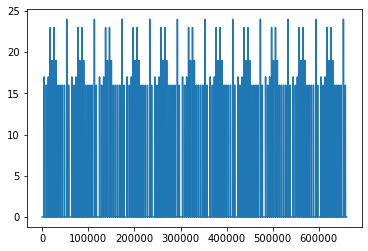

In [169]:
plt.plot(np.sum(eseries_data[orig_time_ind,:]>200,axis=1))

(1650141898.4752865, 1650141898.4802532)

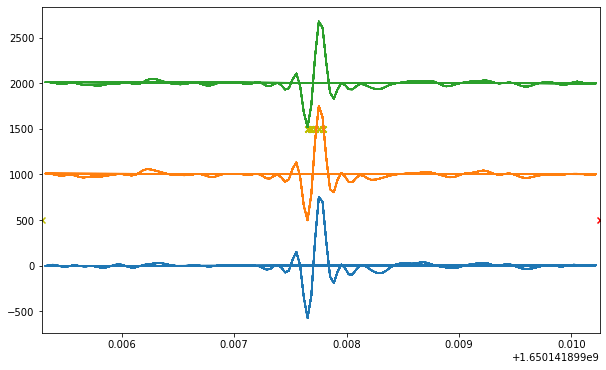

In [192]:
plt.figure(figsize=(10,6))
for i in [25,26,27]:
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+(i-25)*1000)
    
plt.scatter(artifact_plot_times_, np.repeat(1500,artifact_plot_times_.shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [91]:
valid_timestamps[228921343],valid_timestamps[228921344]

(1650156866.382088, 1650135878.0912426)

In [142]:
artifact_ind=np.digitize(artifact_time,np.sort(valid_timestamps))

KeyboardInterrupt: 

In [ ]:
#(SortInterval & {'nwb_file_name' : nwb_copy_file_name,'sort_interval_name' : 'spikesort_maze'}).fetch('sort_interval')[0][6,0]

In [109]:
artifact_ind

array([        0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,  57380928,  57380928, 

In [71]:
artifact_num = 3
plottimes = [artifact_plot_times[artifact_num][0] - 0.005, artifact_plot_times[artifact_num][1] + 0.005]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

In [64]:
#eseries_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1])

In [127]:
np.shape(eseries_data)

(4213342473, 28)

In [128]:
np.shape(valid_timestamps)

(4213342473,)

In [129]:
artifact_time[0]

1650135907.8509383

In [132]:
artifact_plot_times[0,0]

1650135907.848405

In [131]:
valid_timestamps[0]

1650143063.7786002

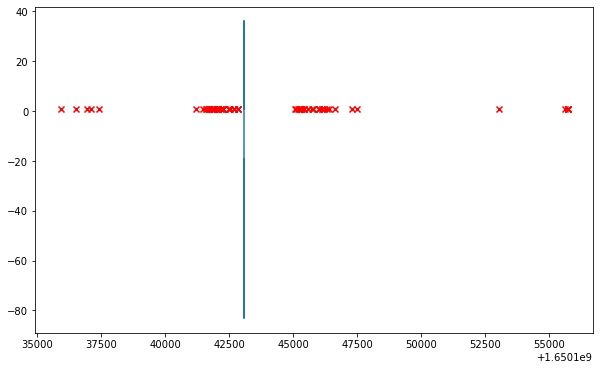

In [130]:
plt.figure(figsize=(10,6))
plt.plot(valid_timestamps[:1000],eseries_data[:1000,0])
plt.scatter(artifact_time,np.ones(np.shape(artifact_time)),marker='x',color='r')

(1650137079.670135, 1650137079.6852353)

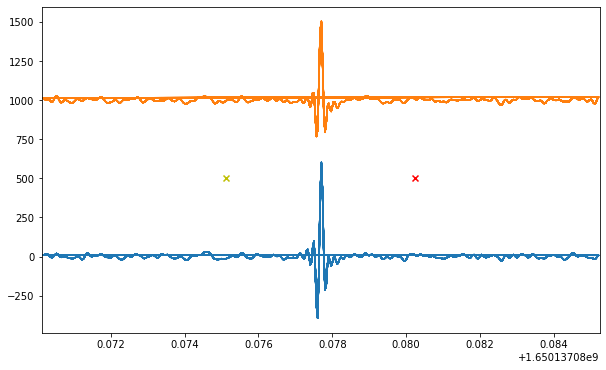

In [72]:
plt.figure(figsize=(10,6))
for i in range(2):
#for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [137]:
plottimes

[1650136504.256454, 1650136504.361554]

In [138]:
valid_timestamps[0]

1650143063.7786002

In [141]:
valid_timestamps[orig_time_ind[0]]

1650136504.2564871

(1650136504.256454, 1650136504.361554)

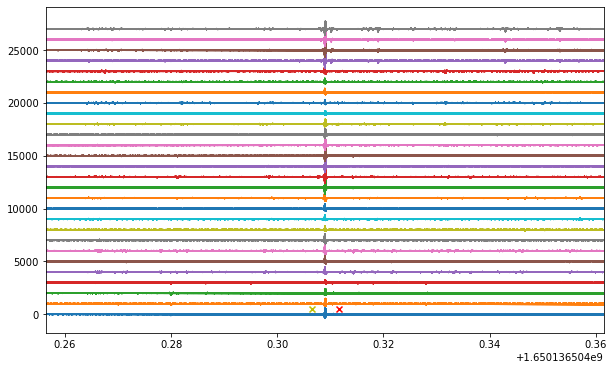

In [135]:
artifact_num = 1
plottimes = [artifact_plot_times[artifact_num][0] - .05, artifact_plot_times[artifact_num][1] + .05]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

plt.figure(figsize=(10,6))
for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

### 4. Spikesorting ```SpikeSortingSelection```,```SpikeSorting```

In [66]:
artifact_params_name='ampl_1000_prop_01'
for tetrode in [3]:    
    artifact_intervals = (ArtifactDetection() 
                          & {'nwb_file_name' : nwb_copy_file_name} 
                          & {'artifact_params_name': artifact_params_name}
                          & {'sort_interval_name':sort_interval_name}
                          & {'sort_group_id' : tetrode}
                         ).fetch('artifact_removed_interval_list_name')[0]
    
    sorting_key = (SpikeSortingRecordingSelection() 
                   & {'nwb_file_name' : nwb_copy_file_name} 
                   & {'sort_interval_name' :sort_interval_name} 
                   & {'sort_group_id' : tetrode}).fetch1('KEY')    
    sorting_key['sorter'] = 'clusterless_thresholder'
    sorting_key['sorter_params_name'] = 'default'
    sorting_key['artifact_removed_interval_list_name'] = artifact_intervals

    SpikeSortingSelection.insert1(sorting_key, skip_duplicates=True)
    SpikeSorting.populate([(SpikeSortingSelection & sorting_key).proj()])

Running spike sorting on {'nwb_file_name': 'molly20220416_.nwb', 'sort_group_id': 3, 'sort_interval_name': 'spikesort_maze', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_ampl_1000_prop_01_artifact_removed_valid_times'}...
Saving sorting results...


In [68]:
SpikeSorting & {'nwb_file_name' : nwb_copy_file_name} 

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
molly20220416_.nwb,3,spikesort_maze,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_ampl_1000_prop_01_artifact_removed_valid_times,/stelmo/nwb/sorting/molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_d2665606_spikesorting,1653405828
